In [67]:
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os


print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

True
NVIDIA GeForce GTX 1050 Ti


In [29]:
# 1.张量 (Tensor) 的创建

data = [[1, 2], [3, 4]]
np_array = np.array(data)
shape = (2, 3,)

x_data = torch.tensor(data) # 从数据生成
x_np = torch.from_numpy(np_array)   # 从ndarray生成
x_ones = torch.ones_like(x_data)    # 形状相同全1张量
x_rand = torch.rand_like(x_data, dtype=torch.float) # 形状相同随机浮点数张量
x_shape = torch.ones(shape) # 从形状生成


# 2.张量的属性
x_data_gpu = torch.tensor(data).to(torch.device("cuda"))

print("Shape = {}\ntype = {}\ndevice = {}".format(x_data.shape, x_data.dtype, x_data.device))
print("device2 = {}".format(x_data_gpu.device))

# 3.切片操作
tensor = torch.tensor(np.arange(12).reshape(3, 4))
print(tensor)
print(tensor[0])
print(tensor[:, -1])
print(tensor[...,2])
print(tensor[1, 2])

Shape = torch.Size([2, 2])
type = torch.int64
device = cpu
device2 = cuda:0
tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])
tensor([0, 1, 2, 3])
tensor([ 3,  7, 11])
tensor([ 2,  6, 10])
tensor(6)
tensor(6)


In [31]:
# 2.数据集(Dataset)和数据加载器(DataLoader)
training_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 6.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 119kB/s]
100%|██████████| 4.42M/4.42M [00:02<00:00, 1.96MB/s]
100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]


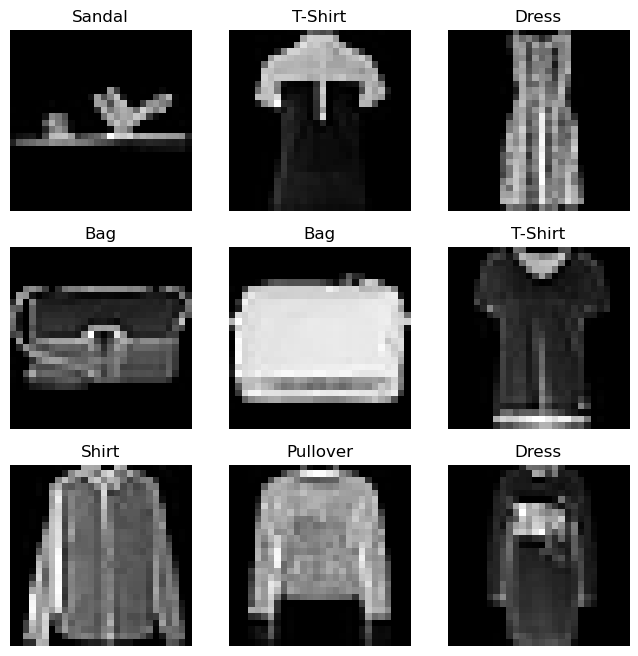

In [38]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()    # 随机选择数据集中的一个样本
    img, label = training_data[sample_idx]  # 返回一个Tensor和对应的label
    figure.add_subplot(rows, cols, i)   # 添加子图
    plt.title(labels_map[label])    # 添加子图标题
    plt.axis("off") # 不显示坐标轴
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

In [ ]:
# 创建自定义数据集
'''
    对于自定义数据集 __init__, __len__, __getitem__三个方法必须实现    
'''

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    

    def __len__(self):
        return len(self.img_labels)
    

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    


Feature shape : torch.Size([64, 1, 28, 28])
Labels  shape : torch.Size([64])


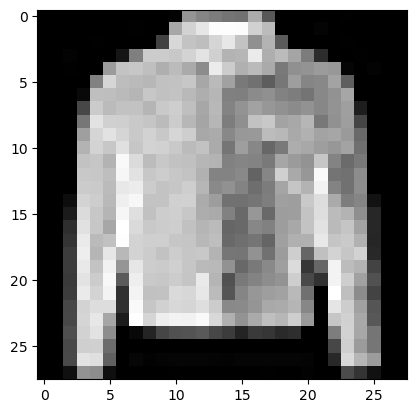

Label : 4 -> Coat


In [66]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader  = DataLoader(test_data, batch_size=64, shuffle=True)

train_features, train_labels = next(iter(train_dataloader))
print("Feature shape : {}".format(train_features.size()))
print("Labels  shape : {}".format(train_labels.size()))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print("Label : {} -> {}".format(label, labels_map[label.item()]))

In [138]:
device = torch.accelerator.current_accelerator().type

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        
        return logits
    

model = NeuralNetwork().to(device)
print(model)

X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(y_pred)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
tensor([4], device='cuda:0')
tensor([4], device='cuda:0')


In [156]:
def relu(array : np.ndarray):
    array[array < 0] = 0


def mean_square_error(array : np.ndarray, target : float) -> float:
    return  0.5 * (array - target)**2



x = np.array([0.5, 1.0])
y = 0.8

weight_input_layer = np.array([[1.0, 0.5],
                               [0.5, 0.7]])


weight_output_layer = np.array([[1.0], 
                                [2.0]])



a1 : np.ndarray = x.dot(weight_input_layer)
relu(a1)
print(a1)

a2 = a1.dot(weight_output_layer)
print(a2)

print("MSE = {}".format(mean_square_error(a2, y)))

d_yhat_w5 = (a2 - y) * (a1[0])
print(d_yhat_w5 - 0.1 * d_yhat_w5)
d_yhat_w1 = (a2 - y) * weight_output_layer[0] * x[0]
print(d_yhat_w1 - 0.1 * d_yhat_w1)


[1.   0.95]
[2.9]
MSE = [2.205]
[1.89]
[0.945]
